In [1]:
# [IMPORTANT Libraries Import]
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import pickle
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt

import glob
from PIL import Image
import re
import shutil
from time import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from segmentation import NumberPlateSegmenter

# Set the TensorFlow log level to suppress info messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set the logging level to suppress warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# [IMPORTANT Function Declaration]
def formulate_dataset(parent_folder_, isImplement=False, no_invert=False):
    X_own_valid = []
    y_own_ = []
    for folder_name in os.listdir(parent_folder_):
        folder_path = os.path.join(parent_folder_, folder_name)
        if os.path.isdir(folder_path):
            image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(".jpg")]
            for i, filename in enumerate(image_files):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    image_path = os.path.join(folder_path, filename)
                    if isImplement:
                        last_char = filename[filename.rfind(".") - 1]
                        y_own_.append(str(last_char))
                    else:
                        first_char = filename[0]
                        y_own_.append(str(first_char))

                    image = cv2.imread(image_path)

                    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    if not no_invert:
                        grayscale_image = (255 - grayscale_image) # type: ignore

                    X_own_valid.append(grayscale_image)

    return np.asarray(X_own_valid).astype(np.float64)/255.0, np.asarray(y_own_)

def fit_pca(X_train, n_components):
    num_samples_train, height, width = X_train.shape
    X_train2d = X_train.reshape(num_samples_train, height * width)

    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train2d.shape[0]))
    # t0 = time()
    
    # Scale the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train2d)

    # Fit PCA on the scaled training data
    pca = RandomizedPCA(n_components=n_components, whiten=True)
    pca.fit(X_train_scaled)
    # print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, height, width))

    # Save the scaler and PCA objects to files
    scaler_path = f'{n_components}_scaler.pkl'
    pca_path = f'{n_components}_pca.pkl'
    
    with open(scaler_path, 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    
    with open(pca_path, 'wb') as pca_file:
        pickle.dump(pca, pca_file)
    
    return pca, scaler, eigenfaces

def transform_data(pca, scaler, data):
    num_samples_train, height, width = data.shape
    data_2d = data.reshape(num_samples_train, height * width)

    # print("Projecting the input data on the eigenfaces orthonormal basis")
    # Scale and transform training data
    data_scaled = scaler.transform(data_2d)
    data_pca = pca.transform(data_scaled)
    
    return data_pca

class RBF_Model(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes, num_prototypes, input_shape, learning_rate, beta):
        self.num_classes = num_classes
        self.num_prototypes = num_prototypes
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.beta = beta
        self.model = None

    def fit(self, x_train, y_train, batch_size, epochs, validation_data):
        checkpoint = keras.callbacks.ModelCheckpoint(f"./saved_models_v2/{self.input_shape[0]}/rbf_{self.input_shape[0]}_{self.num_prototypes}_model", monitor="val_loss", save_best_only=True)
        early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        self.model = self.build_model(x_train)

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])
        history = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                                     validation_data=validation_data, callbacks=[checkpoint, early_stopping], verbose=1)
        return history

    def build_model(self, X):
        model = keras.Sequential()

        print("Initializing K-Means clustering to get RBF centers")
        kmeans = KMeans(n_clusters=self.num_prototypes)
        kmeans.fit(X)
        rbf_centers = kmeans.cluster_centers_
        print("RBF centers Initialized")

        model.add(keras.layers.Dense(self.num_prototypes, input_shape=self.input_shape, activation=self.rbf_activation,
                                      kernel_initializer=keras.initializers.Constant(value=rbf_centers),
                                      trainable=True, name='hidden'))

        model.add(keras.layers.Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5

        # Apply BatchNormalization layer
        model.add(keras.layers.BatchNormalization())  # Add a BatchNormalization layer

        model.add(keras.layers.Dense(self.num_classes, activation='softmax', name='out'))

        return model

    def rbf_activation(self, x):
        return tf.math.exp(-self.beta * tf.square(x))

    def predict(self, X):
        check_is_fitted(self, "model")
        X = check_array(X)
        return self.model.predict(X).argmax(axis=1)

    def evaluate(self, X, y):
        check_is_fitted(self, "model")
        X = check_array(X)
        y_pred = self.predict(X)
        y_true = y.argmax(axis=1)
        print(classification_report(y_true, y_pred))

    @classmethod
    def load_model(cls, filepath, num_classes, num_prototypes, input_shape, learning_rate, beta):
        model = keras.models.load_model(filepath, custom_objects={"rbf_activation": cls.rbf_activation})
        custom_model = cls(num_classes, num_prototypes, input_shape, learning_rate, beta)
        custom_model.model = model
        return custom_model
    
def k_fold_cross_validation(model_, X, y, batch_size, epochs, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    fold_scores = []
    trained_models = []  # List to store trained models

    for i, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Performing Fold: {i+1}")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = model_
        history = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])
        fold_scores.append(history.history['val_accuracy'][-1])
        model_history = history.history
        trained_models.append(model)

    return trained_models, model_history, fold_scores

In [2]:

ver = "v1"
model_comps = 30
model_proto = 700
char_recognition = False

### 1. Load the PCA object and Load PCA And Prediction Dataset
pca_path = f'./pca_weights/{ver}/{model_comps}_pca.pkl'
with open(pca_path, 'rb') as pca_file:
    pca_load = pickle.load(pca_file)

# Load the Scaler object
scaler_path = f'./pca_weights/{ver}/{model_comps}_scaler.pkl'
with open(scaler_path, 'rb') as scaler_file:
    scaler_load = pickle.load(scaler_file)
    
# predict_parent_folder = f"./Datasets/dataset_{ver}.0/prediction_ocr/"
predict_parent_folder = f"./Datasets/dataset_{ver}.0/prediction/"
# predict_parent_folder = f"../Datasets/number_plate/70-100/"
X_predict, y_predict = formulate_dataset(predict_parent_folder, no_invert=True)

pred_label_encoder = LabelEncoder()
y_predict_encoded = pred_label_encoder.fit_transform(y_predict)

Y_pred_char_classes = np.unique(y_predict)

# X_predict Data Transform and y_predict Label Encoding 

X_pca_pred = transform_data(pca_load, scaler_load, X_predict)

X_p, y_p = check_X_y(X_pca_pred, y_predict_encoded)
y_p = tf.keras.utils.to_categorical(y_p, num_classes=36) 

# Load Best RBF-N Model
model_eval = keras.models.load_model(f'./rbf_models/saved_models_{ver}/{model_comps}/rbf_{model_comps}_{model_proto}_model')
model_eval.summary()

model_eval.evaluate(X_p, y_p)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 700)               21700     
                                                                 
 dropout_5 (Dropout)         (None, 700)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 700)              2800      
 hNormalization)                                                 
                                                                 
 out (Dense)                 (None, 36)                25236     
                                                                 
Total params: 49,736
Trainable params: 48,336
Non-trainable params: 1,400
_________________________________________________________________
462/462 [==============================] - 6s 9ms/step - loss: 5.6825 - accuracy: 0.3312


[5.682476043701172, 0.33123305439949036]

1/1 [==============================] - 0s 341ms/step
Predicted Label: ['I'], True Label: Y
1/1 [==============================] - 0s 61ms/step
Predicted Label: ['8'], True Label: 0
1/1 [==============================] - 0s 56ms/step
Predicted Label: ['9'], True Label: P
1/1 [==============================] - 0s 66ms/step
Predicted Label: ['3'], True Label: 3
1/1 [==============================] - 0s 70ms/step
Predicted Label: ['Z'], True Label: 2
1/1 [==============================] - 0s 58ms/step
Predicted Label: ['A'], True Label: A
1/1 [==============================] - 0s 70ms/step
Predicted Label: ['L'], True Label: W
1/1 [==============================] - 0s 63ms/step
Predicted Label: ['W'], True Label: J
1/1 [==============================] - 0s 63ms/step
Predicted Label: ['D'], True Label: D
1/1 [==============================] - 0s 67ms/step
Predicted Label: ['Q'], True Label: 8


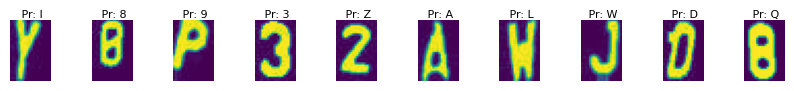

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(10,2))
for i in range(10):
    rand = np.random.randint(0, X_p.shape[0])
    X_predict_ = np.reshape(X_p[rand], (1, 30))
    
    predictions = model_eval.predict(X_predict_)
    predicted_classes = np.argmax(predictions, axis=1)

    predicted_labels = pred_label_encoder.inverse_transform(predicted_classes)
    print(f"Predicted Label: {predicted_labels}, True Label: {y_predict[rand]}")
 
    ax[i].imshow(X_predict[rand])
    ax[i].axis('off')
    ax[i].set_title(f" Pr: {predicted_labels[0]}", fontsize=8, pad=2)
    plt.subplots_adjust(wspace=1) 

plt.show()

1/1 [==============================] - 0s 347ms/step
Predicted Label: ['T'], True Label: T
1/1 [==============================] - 0s 423ms/step
Predicted Label: ['9'], True Label: 9
1/1 [==============================] - 0s 121ms/step
Predicted Label: ['S'], True Label: S
1/1 [==============================] - 0s 131ms/step
Predicted Label: ['F'], True Label: F
1/1 [==============================] - 0s 84ms/step
Predicted Label: ['L'], True Label: L
1/1 [==============================] - 0s 95ms/step
Predicted Label: ['9'], True Label: 9
1/1 [==============================] - 0s 84ms/step
Predicted Label: ['H'], True Label: H
1/1 [==============================] - 0s 105ms/step
Predicted Label: ['I'], True Label: I
1/1 [==============================] - 0s 145ms/step
Predicted Label: ['M'], True Label: M
1/1 [==============================] - 0s 125ms/step
Predicted Label: ['S'], True Label: S
1/1 [==============================] - 0s 128ms/step
Predicted Label: ['9'], True Label: 9
1/

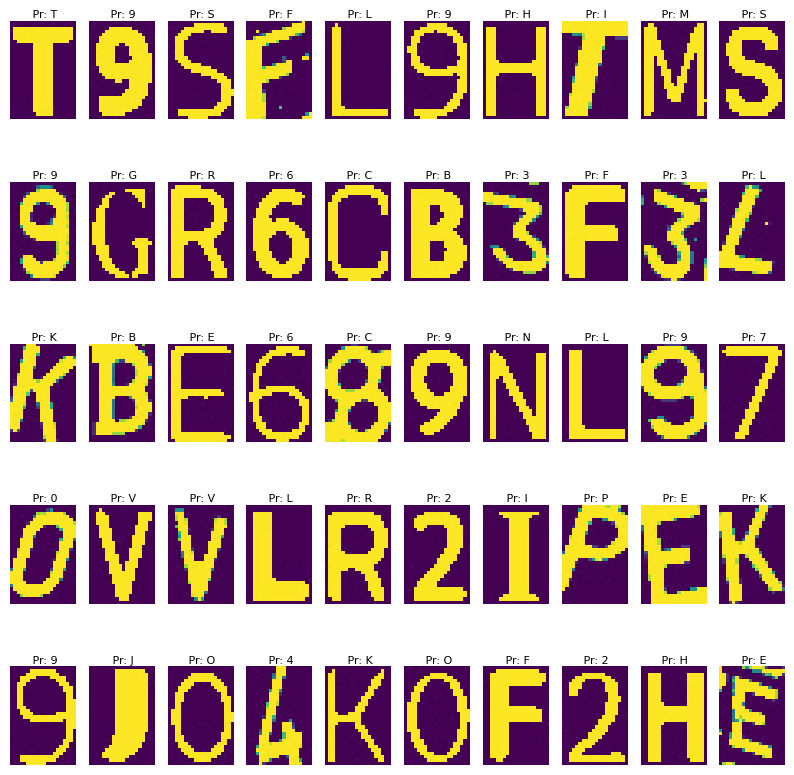

In [3]:
fig, ax = plt.subplots(5, 10, figsize=(10,10))
for row in range(5):
    for col in range(10):
        rand = np.random.randint(0, X_p.shape[0])
        X_predict_ = np.reshape(X_p[rand], (1, 30))
        
        predictions = model_eval.predict(X_predict_)
        predicted_classes = np.argmax(predictions, axis=1)
    
        predicted_labels = pred_label_encoder.inverse_transform(predicted_classes)
        # print(f"Predicted Label: {predicted_labels}, True Label: {y_predict[rand]}")
     
        ax[row, col].imshow(X_predict[rand])
        ax[row, col].axis('off')
        ax[row, col].set_title(f" Pr: {predicted_labels[0]}", fontsize=8, pad=2)
        plt.subplots_adjust(hspace=0.3) 

plt.show()
